In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
!pip install gym

You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
import gym

gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [12]:
#카트위에 놓인 막대가 넘어지지 않도록 왼쪽이나 오른쪽으로 가속할 수 있는 2D 시뮬레이션

env = gym.make("CartPole-v1")
obs = env.reset()
obs

#카프의 수평위치(0.0 = 중앙), 카트의 속도(양수는 우측방향), 막대의 각도(0.0 = 수직), 막대의 각속도(양수는 시계방향)

array([0.01183711, 0.00884842, 0.03295171, 0.01670841])

In [ ]:
!pip install pyvirtualdisplay

In [2]:
import pyvirtualdisplay

pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [10]:
#xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>

env.render()

True

In [11]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

(-0.5, 599.5, 399.5, -0.5)

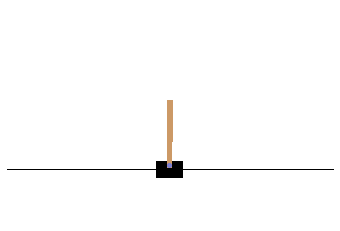

In [13]:
plt.imshow(img)
plt.axis("off")

In [14]:
env.action_space

#가능한 행동이 정수 0과 1 - 각각 왼쪽 가속과 오른쪽 가속

Discrete(2)

In [15]:
action = 1 #오른쪽으로 가속
obs, reward, done, info = env.step(action)
obs, reward, done, info

(array([-0.01642961,  0.19730173,  0.0128838 , -0.2890823 ]), 1.0, False, {})

obs - 새로운 관측값. 카트가 오른쪽으로 가속되었고(obs[1]>0), 막대는 오른쪽으로 기울어 있지만(obs[2]>0), 각속도가 음수이므로(obs[3]<0) 다음 스텝에서는 왼쪽으로 기울어질 가능성이 큼

reward - 항상 1이므로, 가능한 오래 실행하는 것이 목적

done - True가 되면 에피소드 끝.(막대가 너무 기울어지거나, 화면밖으로 나가거나, 200스텝 이상 지나가면 끝) 에피소드가 끝나면 반드시 초기화

info - ex: 에이전트에게 남은 생명

In [26]:
obs.reshape(1, -1), obs[np.newaxis, :]

(array([[-0.18581677, -0.96299384,  0.21459685,  1.17321401]]),
 array([[-0.18581677, -0.96299384,  0.21459685,  1.17321401]]))

In [13]:
#단순 하드코딩

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1 #막대가 왼쪽으로 기울어지면 카트를 왼쪽으로 가속, 오른쪽이라면 반대로

totals = []
for ep in range(500):
    ep_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        ep_rewards += reward
        if done:
            break
    totals.append(ep_rewards)

In [14]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.684, 8.839917646675222, 24.0, 68.0)

72번 보다 많이 실행하지 못했음.

In [15]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [16]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [20]:
plot_animation(frames)

막대 진동이 점점 더 심하게 기울어 진다.

# 신경망 정책

In [22]:
env.observation_space.shape

(4,)

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 #env.observation_space.shape[0]

#왼쪽으로 이동할 확률(0) p를 추측, 오른쪽으로 이동할 확률을 1-p
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid")
])

In [14]:
#학습 없이 실행

def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1)) #한 행에 4개의 입력이 되도록 변형
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [17]:
frames = render_policy_net(model)
plot_animation(frames)

In [18]:
#50개의 환경을 동시에 플레이 시키고 5000번의 반복으로 훈련

n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations).astype(np.float32))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.107

In [19]:
frames = render_policy_net(model)
plot_animation(frames)

# 정책 그래디언트

자동 미분 - 주어진 입력 변수에 대한 연산의 그래디언트를 계산  
GradientTape는 컨텍스트 안에서 실행된 모든 연산을 기록

https://www.tensorflow.org/tutorials/customization/autodiff?hl=ko

In [20]:
#한 스텝을 진행할 함수

def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis]) #하나의 관측과 함께 모델 호출(왼쪽으로 이동할 확률 예측)
        action = (tf.random.uniform([1, 1]) > left_proba) #0~1사이의 랜덤한 실수를 통해 왼쪽(0) 또는 오른쪽(1) 결정
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32) #왼쪽으로 이동할 타겟 확률(왼쪽이면 1 - 0 = 0, 오른쪽이면 1 - 1 = 0)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba)) #손실 계산
    grads = tape.gradient(loss, model.trainable_variables) #훈련가능한 변수에 대한 손실의 그래디언트 계산
    obs, reward, done, info = env.step(int(action[0, 0].numpy())) #선택한 행동을 적용
    return obs, reward, done, grads

In [21]:
#여러 에피소드 플레이 후 전체 보상과 각 에피소드와 스텝의 그래디언트 반환

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [22]:
#각 스텝에서 할인된 미래 보상의 합 계산
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

#여러 에피소드에 걸쳐 계산된 할인 미래 보상의 합에서 평균을 빼고 표준편차를 나누어 정규화
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [23]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

In [24]:
discount_and_normalize_rewards(
    [
        [10, 0, -50], 
        [10, 20]
    ], 
    discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

각 행동에 대해 정규화된 행동 이익

첫 번째 에피소드는 두 번째에 비해 너무 나쁘다(정규화된 이익이 모두 음수)

첫 번째 에피소드의 행동은 모두 나쁜것으로 간주. 두 번째 에피소드의 모든 행동은 좋은 것으로 간주

In [26]:
#훈련 반복 150회, 각 반복은 에피소드 10개, 각 에피소드는 스텝 최대 200번 플레이, 할인 계수 0.95

n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [27]:
optimizer = keras.optimizers.Adam(lr=0.01) #일반적 학습률의 Adam이 무난
loss_fn = keras.losses.binary_crossentropy #이진 분류 이므로

In [28]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [29]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)  #게임 10번 플레이, 각 에피소드와 스텝에 대한 모든 보상과 그래디언트 반환
    total_rewards = sum(map(sum, all_rewards))                     
    print("\rIteration: {}, mean rewards: {:.1f}".format(          
        iteration, total_rewards / n_episodes_per_update), end="") 
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate) #각 행동의 정규화된 이익 계산.
                                                                      #각 행동이 얼마나 좋은지 혹은 나쁜지 확인가능
    all_mean_grads = []
    
    #훈련 가능한 변수를 순회하면서 모든 에피소드와 스텝에 대한 각 변수의 그래디언트를 final_reward로 가중치를 두어 평균 그래디언트 구하기
    for var_index in range(len(model.trainable_variables)): 
        mean_grads = tf.reduce_mean(
            [
                #중첩된 list comprehension은 일반적인 for구문과 똑같은 순서로 실행된다.
                final_reward * all_grads[episode_index][step][var_index]
                    for episode_index, final_rewards in enumerate(all_final_rewards)
                        for step, final_reward in enumerate(final_rewards)
            ], 
            axis=0)
        
        all_mean_grads.append(mean_grads) 
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables)) #평균 그래디언트를 옵티마이저에 적용

env.close()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Iteration: 149, mean rewards: 178.3

In [30]:
frames = render_policy_net(model)
plot_animation(frames)

# TF-Agents 라이브러리

텐서플로우 기반의 강화 학습 라이브러리

In [6]:
!pip install tf-agents --upgrade

Requirement already up-to-date: tf-agents in /usr/local/lib/python3.6/dist-packages (0.5.0)
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
!pip install 'gym[atari]' --upgrade

Requirement already up-to-date: gym[atari] in /root/.local/lib/python3.6/site-packages (0.17.2)
You should consider upgrading via the 'pip install --upgrade pip' command.


In [36]:
!pip install tensorflow-gpu --upgrade

     |████████████████████████████████| 320.4MB 91kB/s s eta 0:00:01     |█████████████▋                  | 135.7MB 11.3MB/s eta 0:00:17
  Using cached https://files.pythonhosted.org/packages/d6/84/759f5dd23fec8ba71952d97bcc7e2c9d7d63bdc582421f3cd4be845f0c98/gast-0.3.3-py2.py3-none-any.whl
     |████████████████████████████████| 51kB 5.6MB/s  eta 0:00:01
     |████████████████████████████████| 460kB 14.1MB/s eta 0:00:01
     |████████████████████████████████| 6.8MB 10.7MB/s eta 0:00:01
     |████████████████████████████████| 788kB 12.6MB/s eta 0:00:01
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: Keras-Preprocessing 1.1.0
    Uninstalling Keras-Preprocessing-1.1.0:
      Successfully uninstalled Keras-Preprocessing-1.1.0
  Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
  Found ex

In [9]:
!pip install tensorflow_probability --upgrade

     |████████████████████████████████| 4.3MB 253kB/s eta 0:00:01
     |████████████████████████████████| 296kB 8.5MB/s eta 0:00:01
  Found existing installation: tensorflow-probability 0.10.1
    Uninstalling tensorflow-probability-0.10.1:
      Successfully uninstalled tensorflow-probability-0.10.1
You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
from tf_agents.environments import suite_gym
env = suite_gym.load("Breakout-v4")
env

ImportError: cannot import name 'TENSOR_SEED_MSG_PREFIX'

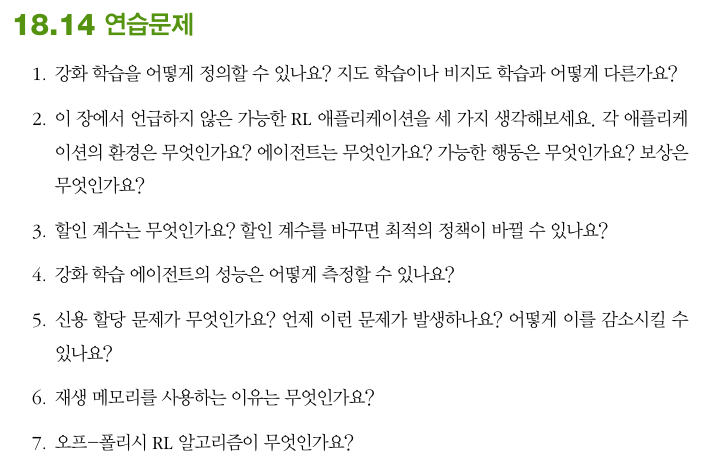

1. 강화학습(RL)은 주어진 환경에서 시간이 지남에 따라 보상이 최대화되는 행동을 할 수 있는 에이전트를 만드는 것을 목적으로 함.  
   - 지도학습과 비지도학습의 목적은 데이터에 있는 패턴을 찾아 이를 사용해 예측. 강화 학습의 목적은 좋은 정책을 찾는 것.  
   - 지도학습과 달리 올바른 정답이 명시적으로 주어지지 않음. 시행착오를 통해 학습  
   - 비지도 학습과 달리 보상을 통한 감독
   - 새로운 방식을 찾는 환경의 탐험과 이미 알고 있는 보상 방법을 활용하는 것 사이에 적절한 균형 필요
   

2. 
   - 음악 개인화 : 개인화된 웹 라디오. 다음에 어떤 노래를 재생할지 결정  
     사용자가 노래를 들을 때 마다 작은 보상, 광고를 들을 때 마다 큰 보상.  
     노래를 스킵하면 작은 음수의 보상, 사용자가 떠나면 큰 음수의 보상
     
   - 마케팅 : 고객 프로파일과 구매 이력을 바탕으로 어떤 고객에에 홍보 메일을 보낼지 결정하는 소프트웨어
     발송 비용에 대해 음수의 보상, 예상 매출을 양수의 보상
     
   - 제품 배송 : 상품이 제시간에 도착하면 보상, 배송 지연시 음수의 보상
   
   
3. 즉시 받을 수 있는 보상에 큰 가중치 나중에 받을 수 있는 보상에 낮은 가중치  
   이를 모델링 하기 위해 타임 스텝 마다 할인 계수 적용  
   할인 계수가 0.9일 때 2번의 타임 스탭 후에 받을 100의 보상은 (0.9*0.9) * 100 = 81  
   1에 가까우면 현재와 미래의 가치는 거의 동일
   
   
4. 간단하게 얻은 보상을 모두 더하면 된다


5. 강화 학습 에이전트가 보상을 받을 때 이 보상과 관련된 행동이 무엇이었는지 알기 어렵다는 것  
   해결책으로 에이전트에 가능하면 단기 보상을 제공하는 것.
   
   
6. 에이전트가 최근 경험과 최근이 아닌 경험들을 담은 버퍼에 기초하여 학습하게 함


7. 에이전트가 최적이 아닌 정책을 따르는 동안 최적 정책의 가치를 학습(Q-러닝)  